In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import f1_score
import pickle

# dimensionality reduction
from sklearn.decomposition import PCA
from featurewiz import featurewiz

# import own functions
from ipynb.fs.full.Functions import load_train_test_data, model_eval

# fix random seed
np.random.seed(0)
torch.manual_seed(0)
import random
random.seed(0)
# all seeds where randomness could be introduced are set, the only "randomness" left is within CUDAs convolution 
# benchmarking as well as choice of non-deterministic algorithms (https://pytorch.org/docs/stable/notes/randomness.html)

In [40]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df)
num_classes = y_train.nunique()

A snippet of the data:


,duration,mean,median,max,min,var,std,speaking_rate,articulation_rate,asd,...,lpc_local2_max,lpc_local2_min,lpc_local3_mean,lpc_local3_var,lpc_local3_max,lpc_local3_min,lpc_local4_mean,lpc_local4_var,lpc_local4_max,lpc_local4_min
241,1.080531,0.798864,0.120244,-1.545379,-0.652108,0.523898,0.658707,-1.111672,-0.558179,0.331673,...,-0.091637,0.185348,-0.022061,0.441684,0.742017,0.170993,-0.831143,0.614467,-0.732472,-1.188202
364,0.720034,-1.009939,-0.702861,-0.141995,-0.651093,-0.969902,-1.111441,-0.398964,0.017716,-0.177987,...,-0.006601,-1.492591,-0.368749,-0.139361,1.480235,-0.231258,1.224370,-0.415187,0.334343,-0.828224
209,1.225277,-0.809615,-0.966255,0.733353,1.901097,-0.657665,-0.656852,-0.139340,0.054715,-0.207189,...,1.482137,-0.166135,-0.823332,1.932349,1.213764,-1.282582,0.709022,-0.032655,0.569388,1.013341
430,0.310436,-0.863672,-0.684753,0.296739,-0.651347,-0.873055,-0.962529,0.930037,0.782669,-0.712995,...,-0.561809,0.477222,0.533654,-0.324134,1.894395,0.446397,0.119924,1.313053,1.608743,0.209010
309,-0.541554,1.990422,2.001863,-1.172855,-0.651601,1.882264,1.798970,1.191835,1.071873,-0.883360,...,-0.382020,-0.780989,0.300999,-0.464952,-0.035383,0.332772,0.015900,0.198858,-0.961507,-0.669726


There are 454 entries with 269 columns in the training data.
There are 81 entries with 269 columns in the testing data.


In [41]:
# split test set into validation and test data
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test')

A snippet of the data:


,duration,mean,median,max,min,var,std,speaking_rate,articulation_rate,asd,...,lpc_local2_max,lpc_local2_min,lpc_local3_mean,lpc_local3_var,lpc_local3_max,lpc_local3_min,lpc_local4_mean,lpc_local4_var,lpc_local4_max,lpc_local4_min
50,-0.467142,1.539161,-0.322586,0.530244,-0.652108,2.430749,2.197872,-1.446222,-0.420712,0.199741,...,-0.145771,-0.196305,0.924303,-0.178766,1.372307,0.272413,-0.409028,-0.286915,-0.416701,0.458420
117,-0.985224,0.249976,0.339190,-0.054813,-0.652108,-0.041486,0.085751,1.483441,1.394006,-1.056562,...,1.353385,-0.816315,-1.345975,1.236637,-1.161719,-0.923485,1.345415,-0.278766,0.473583,-0.183992
190,-0.678938,0.829002,-0.301186,-1.202544,-0.651347,1.323608,1.360837,-1.089735,-0.503961,0.278790,...,0.869338,1.208752,0.213359,0.489673,0.632119,-0.381577,-0.054725,0.433072,-0.564056,-2.341725
285,-1.281349,-0.185806,-0.255092,-1.059048,-0.651601,-0.143899,-0.027428,-0.262226,-0.534406,0.308346,...,-1.332474,-1.707342,0.640900,-1.058476,-0.513609,1.550436,0.648974,-1.035110,0.253674,1.668666
310,0.303987,2.509715,2.604376,0.672797,-0.652108,2.694004,2.380136,-0.145141,-0.405064,0.185164,...,-1.434737,-1.147096,1.371393,-1.014957,0.931459,1.606500,-0.736454,0.261126,-0.249325,-1.571203


There are 40 entries with 269 columns in the validation data.
There are 41 entries with 269 columns in the testing data.


In [42]:
# define a tabluar dataset with torch
class TabularDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data.iloc[idx].values, dtype=torch.float)
        y = torch.tensor(self.target.iloc[idx], dtype=torch.long)
        return x, y

In [43]:
# GPU device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)

# set hyperparameters
BATCH_SIZE = 32
HIDDEN_SIZE = 64
EPOCHS = 25
patience = 2

Device state: cpu


In [49]:
# to make dataloader reproducable (https://pytorch.org/docs/stable/notes/randomness.html)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [56]:
# define train, test, and val loader
train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, 
                       worker_init_fn=seed_worker,generator=g)

# MLP-FFNN

In [51]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.layer3(x)
        return x

In [62]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [53]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, batch_size=BATCH_SIZE, num_epochs=EPOCHS, patience=patience):
    # set random seed
    torch.manual_seed(0)
    np.random.seed(0)
    torch.cuda.manual_seed(0)
    
    train_losses = []
    val_losses = []
    val_f1_scores = []
    best_val_f1_score = 0.0
    no_improvement_count = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.tolist())
                val_labels.extend(labels.tolist())
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        val_f1_scores.append(val_f1)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1 Macro: {val_f1:.4f}")
        
        if val_f1 > best_val_f1_score:
            best_val_f1_score = val_f1
            best_model_weights = model.state_dict()
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count == patience:
                print(f"No improvement in val F1 macro score for {patience} epochs, stopping training early")
                break
        
    model.load_state_dict(best_model_weights)
    return model, train_losses, val_losses, val_f1_scores

In [10]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.8222, Val Loss: 1.6959, Val F1 Macro: 0.3294
Epoch 2/25, Train Loss: 1.4374, Val Loss: 1.5506, Val F1 Macro: 0.4514
Epoch 3/25, Train Loss: 1.1338, Val Loss: 1.2720, Val F1 Macro: 0.4928
Epoch 4/25, Train Loss: 0.9228, Val Loss: 0.9188, Val F1 Macro: 0.5450
Epoch 5/25, Train Loss: 0.7393, Val Loss: 0.9221, Val F1 Macro: 0.6277
Epoch 6/25, Train Loss: 0.6127, Val Loss: 0.6969, Val F1 Macro: 0.6320
Epoch 7/25, Train Loss: 0.4600, Val Loss: 0.6905, Val F1 Macro: 0.6696
Epoch 8/25, Train Loss: 0.3719, Val Loss: 0.7409, Val F1 Macro: 0.7575
Epoch 9/25, Train Loss: 0.3181, Val Loss: 0.8802, Val F1 Macro: 0.7985
Epoch 10/25, Train Loss: 0.2523, Val Loss: 0.6630, Val F1 Macro: 0.8397
Epoch 11/25, Train Loss: 0.2276, Val Loss: 0.6531, Val F1 Macro: 0.8473
Epoch 12/25, Train Loss: 0.1719, Val Loss: 0.7929, Val F1 Macro: 0.8515
Epoch 13/25, Train Loss: 0.1406, Val Loss: 0.4136, Val F1 Macro: 0.8384
Epoch 14/25, Train Loss: 0.1217, Val Loss: 0.7844, Val F1 Macro: 0.8975
E


Evaluation: f1_score
99.57% for the train data
81.58% for the test data

Evaluation: accuracy_score
99.56% for the train data
85.37% for the test data

Evaluation: precision_score
99.63% for the train data
89.90% for the test data

Evaluation: recall_score
99.52% for the train data
80.95% for the test data

Evaluation: confusion_matrix of test predictions


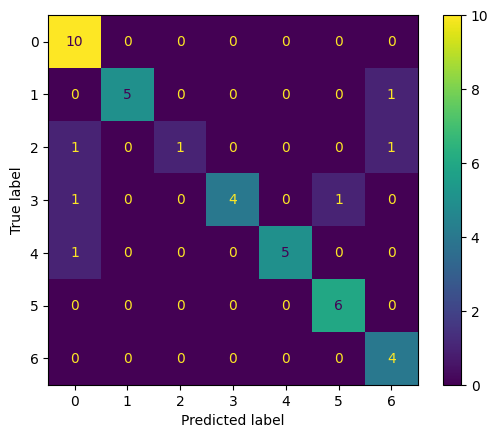


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'sadness(6)']



In [11]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

In [12]:
# save model
pickle.dump(model, open('../results/models/MLPFFNN_best_model_all_numerical_features.pkl', 'wb'))

# GFFNN (skip connections)

In [8]:
class MLPWithSkip(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPWithSkip, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        self.skip_connection = nn.Linear(input_size, hidden_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        hidden1 = self.relu(self.fc1(x))
        hidden2 = self.relu(self.fc2(hidden1))
        
        # Apply skip connection from input to second hidden layer
        skip = self.skip_connection(x)
        hidden2_skip = hidden2 + skip
        
        output = self.fc3(hidden2_skip)
        return output

In [9]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [15]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.4954, Val Loss: 1.2778, Val F1 Macro: 0.4518
Epoch 2/25, Train Loss: 0.9119, Val Loss: 1.1691, Val F1 Macro: 0.5547
Epoch 3/25, Train Loss: 0.6864, Val Loss: 0.9944, Val F1 Macro: 0.5643
Epoch 4/25, Train Loss: 0.5492, Val Loss: 0.6039, Val F1 Macro: 0.6753
Epoch 5/25, Train Loss: 0.4348, Val Loss: 0.7281, Val F1 Macro: 0.6554
Epoch 6/25, Train Loss: 0.3897, Val Loss: 0.6064, Val F1 Macro: 0.7167
Epoch 7/25, Train Loss: 0.2927, Val Loss: 0.5481, Val F1 Macro: 0.8190
Epoch 8/25, Train Loss: 0.2425, Val Loss: 0.5449, Val F1 Macro: 0.8190
Epoch 9/25, Train Loss: 0.2079, Val Loss: 0.7370, Val F1 Macro: 0.7951
No improvement in val F1 macro score for 2 epochs, stopping training early



Evaluation: f1_score
96.50% for the train data
83.35% for the test data

Evaluation: accuracy_score
96.48% for the train data
87.80% for the test data

Evaluation: precision_score
96.78% for the train data
90.48% for the test data

Evaluation: recall_score
96.33% for the train data
82.14% for the test data

Evaluation: confusion_matrix of test predictions


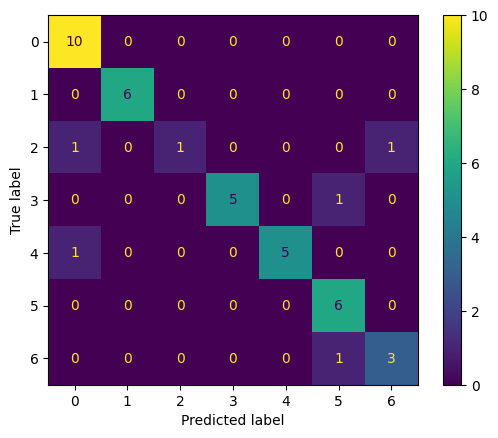


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'sadness(6)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['disgust(2)']



In [16]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

## Repeat with most important features
### MLP

In [63]:
# load the data with most important features
df = pd.read_pickle('../results/df_prep_most_important97.pkl')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df, test_size=0.3)
num_classes = y_train.nunique()
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)

A snippet of the data:


,rms_min,mfccs5_mean,zcr_max,duration_rising_pitch_max,lpccs_local4_min,lfccs9_max,min,energy_median,lfccs0_median,lpccs_global_median,...,value_falling_pitch_min,log_energy_entropy_mean,duration_falling_pitch_max,mfccs8_min,delta2_mfccs6_var,rms_max,f1_avg_change_rate_max,lpc_local1_var,f4_std,value_falling_pitch_max
383,-0.619440,-0.883268,1.389597,-0.431252,-0.059150,-0.874059,0.461556,0.732972,1.231243,-0.349875,...,0.553724,1.763171,-0.158909,-0.272260,0.424229,-0.604866,-0.371080,0.342967,1.053712,-0.036110
180,1.111373,2.981771,-2.109380,-0.348035,0.503161,0.652309,-0.652108,1.744806,-0.446723,-0.711983,...,-2.365758,1.327334,0.974641,0.539483,-0.076613,0.048643,0.343799,-0.747024,0.117057,0.323015
447,2.035391,2.016252,-0.712467,-0.472861,-0.813299,-0.060700,-0.650839,0.576918,2.368897,-1.147182,...,0.734583,-1.736709,-1.211491,0.700281,0.123406,0.517849,2.483163,-0.211176,0.684359,0.302117
409,-0.601969,-0.067690,0.492538,-0.472861,0.688789,-1.108780,3.283787,0.199894,1.001981,1.232069,...,-0.071742,0.232601,1.703351,0.593645,3.025175,-1.511575,-2.120813,-0.853909,-0.650691,0.243999
268,-0.727106,-1.481929,-1.069505,-0.389644,1.148437,-1.773846,-0.193242,0.125970,0.573460,0.855085,...,0.853313,1.048484,-0.401812,-0.012374,0.843503,-1.059211,-1.728739,-0.511559,-0.772848,0.327307


There are 374 entries with 97 columns in the training data.
There are 161 entries with 97 columns in the testing data.


In [64]:
# define train, test, and val loader
train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, 
                       worker_init_fn=seed_worker,generator=g)

In [52]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [53]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.8690, Val Loss: 1.7369, Val F1 Macro: 0.3105
Epoch 2/25, Train Loss: 1.6644, Val Loss: 1.5211, Val F1 Macro: 0.3544
Epoch 3/25, Train Loss: 1.4213, Val Loss: 1.2662, Val F1 Macro: 0.3632
Epoch 4/25, Train Loss: 1.1882, Val Loss: 1.1151, Val F1 Macro: 0.3800
Epoch 5/25, Train Loss: 0.9847, Val Loss: 0.9495, Val F1 Macro: 0.5589
Epoch 6/25, Train Loss: 0.8365, Val Loss: 0.8123, Val F1 Macro: 0.6566
Epoch 7/25, Train Loss: 0.7055, Val Loss: 0.7316, Val F1 Macro: 0.6769
Epoch 8/25, Train Loss: 0.6036, Val Loss: 0.6852, Val F1 Macro: 0.6812
Epoch 9/25, Train Loss: 0.5154, Val Loss: 0.6100, Val F1 Macro: 0.7444
Epoch 10/25, Train Loss: 0.4446, Val Loss: 0.5466, Val F1 Macro: 0.7427
Epoch 11/25, Train Loss: 0.3759, Val Loss: 0.5349, Val F1 Macro: 0.7450
Epoch 12/25, Train Loss: 0.3209, Val Loss: 0.4905, Val F1 Macro: 0.7694
Epoch 13/25, Train Loss: 0.2753, Val Loss: 0.5084, Val F1 Macro: 0.7952
Epoch 14/25, Train Loss: 0.2321, Val Loss: 0.4845, Val F1 Macro: 0.8055
E


Evaluation: f1_score
99.55% for the train data
72.38% for the test data

Evaluation: accuracy_score
99.47% for the train data
72.84% for the test data

Evaluation: precision_score
99.69% for the train data
73.62% for the test data

Evaluation: recall_score
99.43% for the train data
72.07% for the test data

Evaluation: confusion_matrix of test predictions


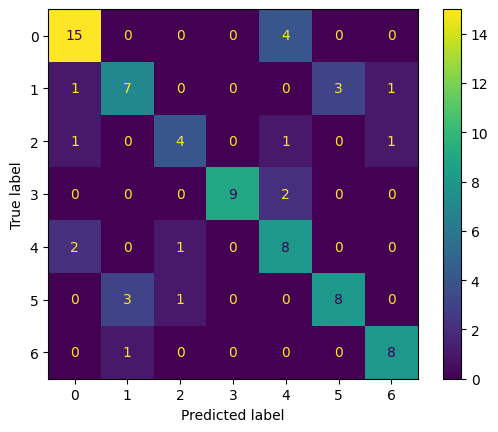


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [54]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### GFFNN

In [67]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [68]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.7838, Val Loss: 1.3847, Val F1 Macro: 0.4642
Epoch 2/25, Train Loss: 1.2671, Val Loss: 1.0812, Val F1 Macro: 0.5777
Epoch 3/25, Train Loss: 0.9870, Val Loss: 0.8815, Val F1 Macro: 0.6751
Epoch 4/25, Train Loss: 0.8010, Val Loss: 0.7719, Val F1 Macro: 0.7416
Epoch 5/25, Train Loss: 0.6642, Val Loss: 0.6567, Val F1 Macro: 0.7748
Epoch 6/25, Train Loss: 0.5715, Val Loss: 0.5810, Val F1 Macro: 0.7618
Epoch 7/25, Train Loss: 0.4889, Val Loss: 0.5518, Val F1 Macro: 0.7823
Epoch 8/25, Train Loss: 0.4183, Val Loss: 0.5501, Val F1 Macro: 0.7816
Epoch 9/25, Train Loss: 0.3564, Val Loss: 0.4907, Val F1 Macro: 0.8248
Epoch 10/25, Train Loss: 0.3066, Val Loss: 0.4625, Val F1 Macro: 0.8256
Epoch 11/25, Train Loss: 0.2585, Val Loss: 0.4511, Val F1 Macro: 0.8360
Epoch 12/25, Train Loss: 0.2192, Val Loss: 0.4488, Val F1 Macro: 0.8224
Epoch 13/25, Train Loss: 0.1880, Val Loss: 0.4684, Val F1 Macro: 0.8311
No improvement in val F1 macro score for 2 epochs, stopping training earl


Evaluation: f1_score
97.89% for the train data
78.08% for the test data

Evaluation: accuracy_score
97.86% for the train data
77.78% for the test data

Evaluation: precision_score
98.11% for the train data
80.00% for the test data

Evaluation: recall_score
97.72% for the train data
77.69% for the test data

Evaluation: confusion_matrix of test predictions


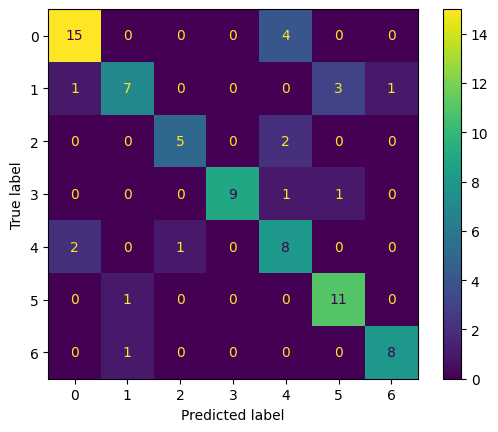


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']



In [69]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

# Test for features paper 1
Since lists/arrays in features are not working for simple Feed Forward Neural Nets first try with statistics:

In [10]:
# load dataframe with all entries (not only numerical) - note that they are not scaled / further preprocessed
df_all_stats = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')
df_paper1 = df_all_stats.filter(regex='label|^var$|^min$|^median$|lpc_|log_energy_entropy|shannon_entropy|threshold_entropy|sure_entropy|rms|f0|f1|f2|f3|f4')
df_paper1.columns.to_list()

['median',
 'min',
 'var',
 'f1_median',
 'f1_max',
 'f1_mean',
 'f1_std',
 'f1_var',
 'f2_median',
 'f2_max',
 'f2_mean',
 'f2_std',
 'f2_var',
 'f3_median',
 'f3_max',
 'f3_mean',
 'f3_std',
 'f3_var',
 'f4_median',
 'f4_max',
 'f4_mean',
 'f4_std',
 'f4_var',
 'rms_max',
 'rms_min',
 'rms_mean',
 'rms_median',
 'rms_var',
 'log_rms_max',
 'log_rms_min',
 'log_rms_mean',
 'log_rms_median',
 'log_rms_var',
 'lpc_global_max',
 'lpc_global_min',
 'lpc_global_mean',
 'lpc_global_median',
 'lpc_global_var',
 'lpc_local1_max',
 'lpc_local1_min',
 'lpc_local1_mean',
 'lpc_local1_median',
 'lpc_local1_var',
 'lpc_local2_max',
 'lpc_local2_min',
 'lpc_local2_mean',
 'lpc_local2_median',
 'lpc_local2_var',
 'lpc_local3_max',
 'lpc_local3_min',
 'lpc_local3_mean',
 'lpc_local3_median',
 'lpc_local3_var',
 'lpc_local4_max',
 'lpc_local4_min',
 'lpc_local4_mean',
 'lpc_local4_median',
 'lpc_local4_var',
 'shannon_entropy_max',
 'shannon_entropy_mean',
 'shannon_entropy_median',
 'shannon_entropy_

In [4]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_paper1, test_size=0.3)
num_classes = y_train.nunique()
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)

A snippet of the data:


,median,min,var,f1_median,f1_max,f1_mean,f1_std,f1_var,f2_median,f2_max,...,f3_avg_change_rate_min,f3_avg_change_rate_mean,f3_avg_change_rate_median,f3_avg_change_rate_var,f4_min,f4_avg_change_rate_max,f4_avg_change_rate_min,f4_avg_change_rate_mean,f4_avg_change_rate_median,f4_avg_change_rate_var
383,-0.039438,0.461556,-0.381409,0.109975,0.749154,-0.095229,-0.520755,-0.534501,1.592832,-0.520892,...,-0.447810,-0.510516,0.645651,-0.446794,-0.368305,-0.085934,0.512051,-0.870717,0.075705,-0.297362
180,1.899798,-0.652108,0.731989,-0.779346,0.422193,0.956602,2.375949,2.605727,-1.422960,1.926849,...,-0.833236,-0.347630,-1.235885,3.675838,-0.340975,0.828280,0.175893,-1.045572,0.205391,1.721040
447,2.525357,-0.650839,1.041327,-1.020266,2.563538,1.474111,3.109221,3.737540,0.321433,0.682151,...,-1.132030,-0.406939,-0.650150,3.190222,-0.195910,-0.455604,0.037605,-0.167319,-0.302759,0.988848
409,-0.939915,3.283787,-0.993784,0.668347,-0.834384,0.321871,-0.759715,-0.698713,-0.863763,-0.835770,...,1.091889,-0.742762,-0.222430,-1.047834,-0.120180,-1.574842,1.633455,-0.273976,-0.429416,-1.012552
268,-0.643597,-0.193242,-0.656372,1.656957,1.938499,1.243244,-0.616808,-0.602245,-0.963181,0.151561,...,0.188001,-1.364033,0.282093,-0.921787,-1.000672,-2.123276,1.680816,-0.474901,0.176639,-1.356359


There are 374 entries with 108 columns in the training data.
There are 161 entries with 108 columns in the testing data.


In [11]:
# define train, test, and val loader
train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, 
                       worker_init_fn=seed_worker,generator=g)

### MLP

In [93]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [94]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.8743, Val Loss: 1.7928, Val F1 Macro: 0.1952
Epoch 2/25, Train Loss: 1.6834, Val Loss: 1.6185, Val F1 Macro: 0.2902
Epoch 3/25, Train Loss: 1.4847, Val Loss: 1.4089, Val F1 Macro: 0.3105
Epoch 4/25, Train Loss: 1.2779, Val Loss: 1.2673, Val F1 Macro: 0.3573
Epoch 5/25, Train Loss: 1.0977, Val Loss: 1.1285, Val F1 Macro: 0.4645
Epoch 6/25, Train Loss: 0.9615, Val Loss: 1.0279, Val F1 Macro: 0.4920
Epoch 7/25, Train Loss: 0.8447, Val Loss: 0.9577, Val F1 Macro: 0.6244
Epoch 8/25, Train Loss: 0.7318, Val Loss: 0.8337, Val F1 Macro: 0.6640
Epoch 9/25, Train Loss: 0.6403, Val Loss: 0.8498, Val F1 Macro: 0.7224
Epoch 10/25, Train Loss: 0.5660, Val Loss: 0.6932, Val F1 Macro: 0.7498
Epoch 11/25, Train Loss: 0.4864, Val Loss: 0.6379, Val F1 Macro: 0.7871
Epoch 12/25, Train Loss: 0.4290, Val Loss: 0.6304, Val F1 Macro: 0.7702
Epoch 13/25, Train Loss: 0.3763, Val Loss: 0.6369, Val F1 Macro: 0.7630
No improvement in val F1 macro score for 2 epochs, stopping training earl


Evaluation: f1_score
91.83% for the train data
57.54% for the test data

Evaluation: accuracy_score
91.98% for the train data
60.49% for the test data

Evaluation: precision_score
92.31% for the train data
58.43% for the test data

Evaluation: recall_score
91.89% for the train data
57.97% for the test data

Evaluation: confusion_matrix of test predictions


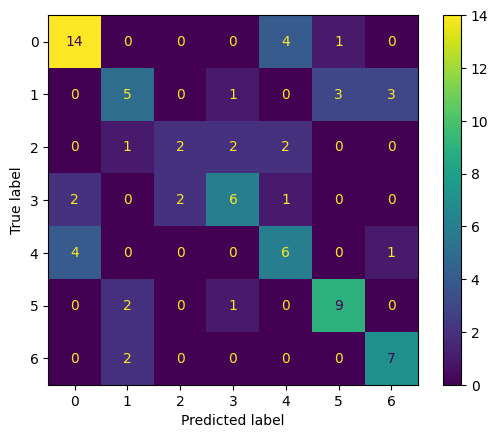


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)', 'sadness(6)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)', 'happiness(4)']
Hard cases of false positives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [95]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### GFFNN

In [96]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [97]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.7202, Val Loss: 1.4547, Val F1 Macro: 0.3836
Epoch 2/25, Train Loss: 1.2915, Val Loss: 1.2179, Val F1 Macro: 0.5273
Epoch 3/25, Train Loss: 1.0803, Val Loss: 1.0519, Val F1 Macro: 0.5679
Epoch 4/25, Train Loss: 0.9198, Val Loss: 0.9887, Val F1 Macro: 0.6096
Epoch 5/25, Train Loss: 0.8100, Val Loss: 0.8454, Val F1 Macro: 0.6718
Epoch 6/25, Train Loss: 0.7262, Val Loss: 0.8096, Val F1 Macro: 0.6920
Epoch 7/25, Train Loss: 0.6491, Val Loss: 0.7656, Val F1 Macro: 0.7084
Epoch 8/25, Train Loss: 0.5661, Val Loss: 0.6930, Val F1 Macro: 0.7073
Epoch 9/25, Train Loss: 0.4998, Val Loss: 0.7168, Val F1 Macro: 0.7562
Epoch 10/25, Train Loss: 0.4474, Val Loss: 0.6105, Val F1 Macro: 0.7554
Epoch 11/25, Train Loss: 0.3864, Val Loss: 0.5734, Val F1 Macro: 0.7538
No improvement in val F1 macro score for 2 epochs, stopping training early



Evaluation: f1_score
93.04% for the train data
68.79% for the test data

Evaluation: accuracy_score
93.05% for the train data
69.14% for the test data

Evaluation: precision_score
92.92% for the train data
72.02% for the test data

Evaluation: recall_score
93.20% for the train data
68.44% for the test data

Evaluation: confusion_matrix of test predictions


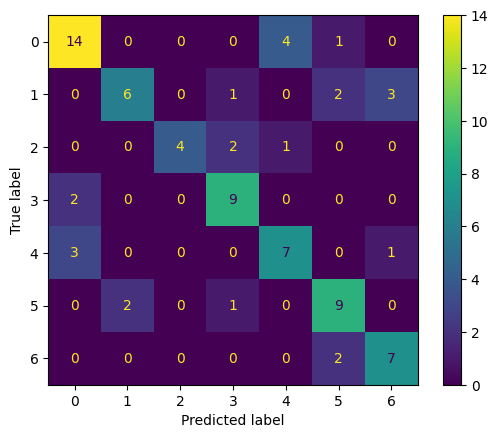


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['boredom(1)']



In [98]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

## Feature Selection for Paper 1

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (535, 109)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

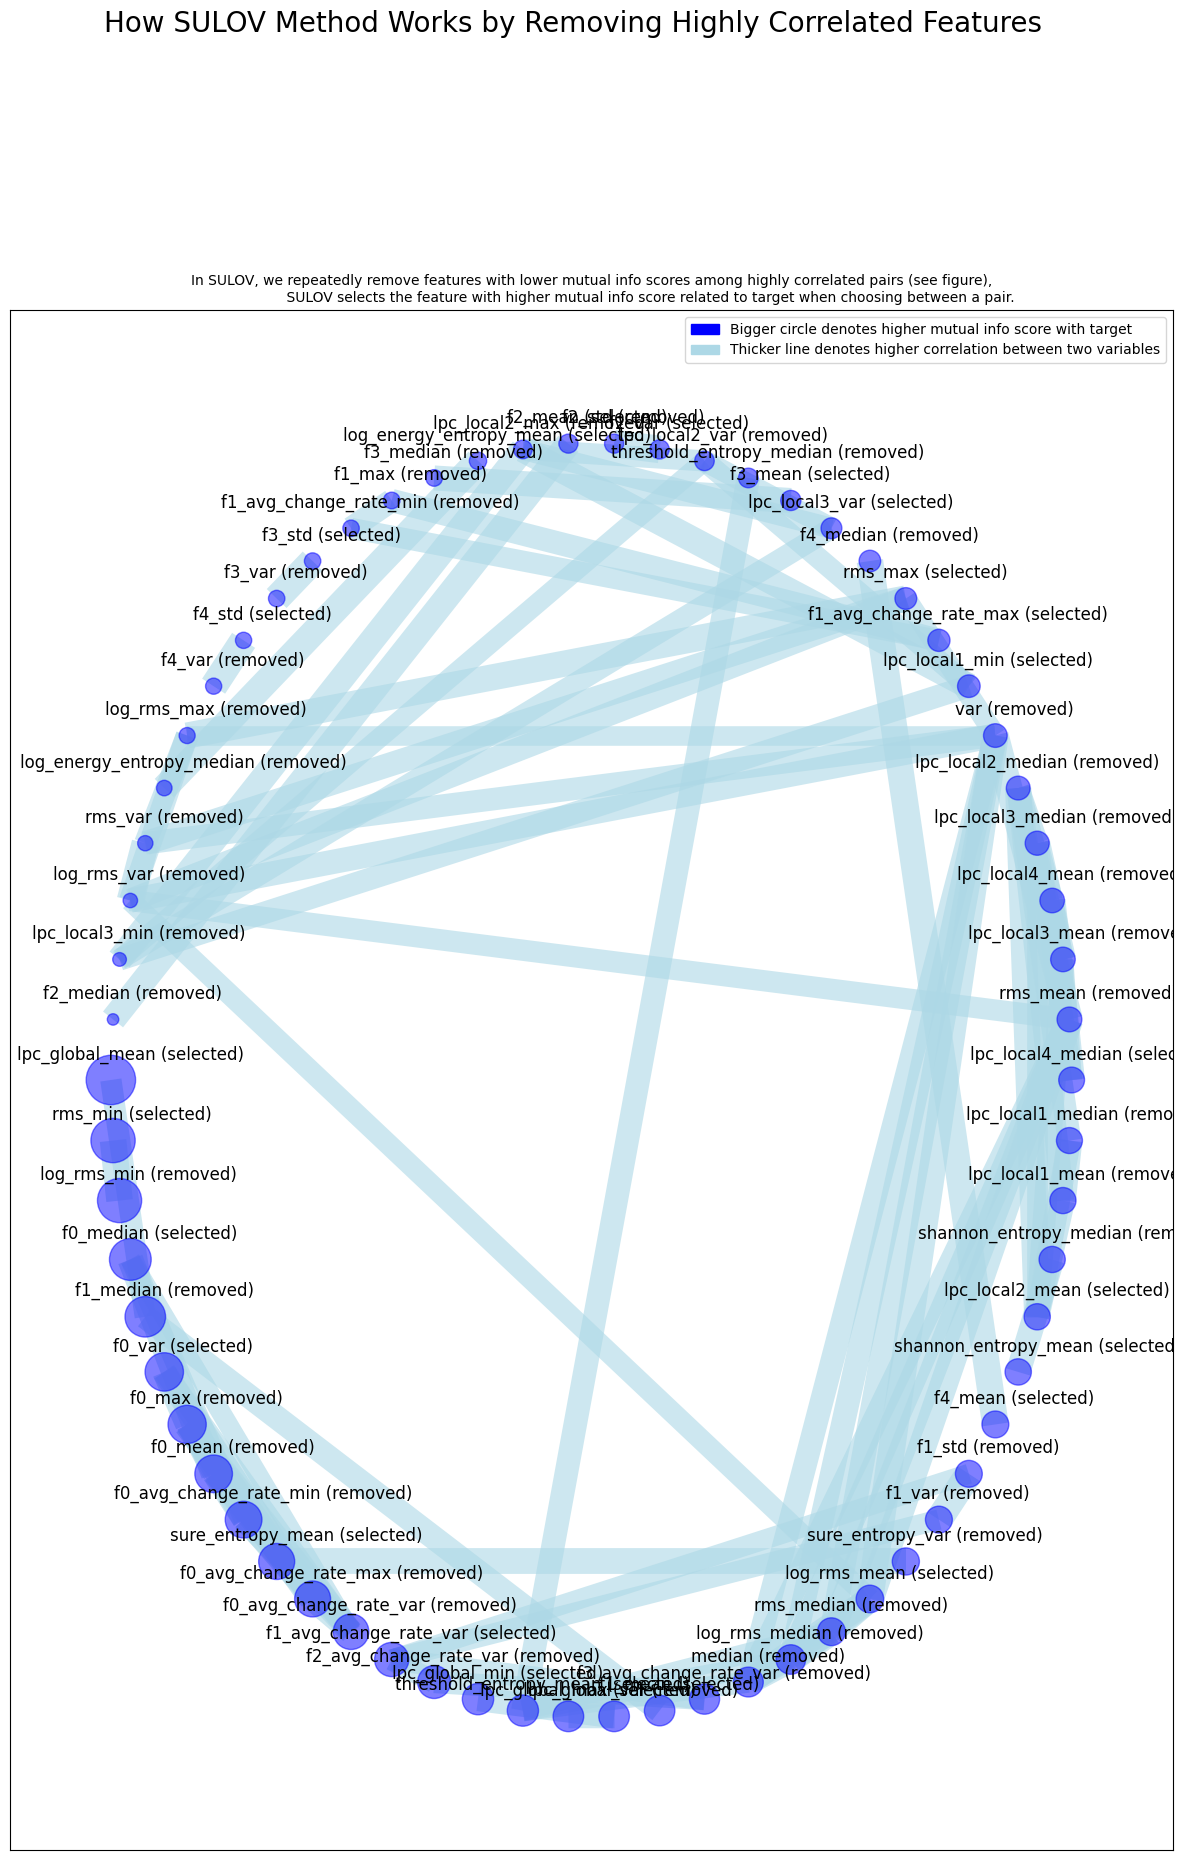

Time taken for SULOV method = 2 seconds
    Adding 0 categorical variables to reduced numeric variables  of 67
Finally 67 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 67 
    Taking top 16 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 67 variables...
            selecting 13 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
        using 54 variables...
            selecting 8 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
 

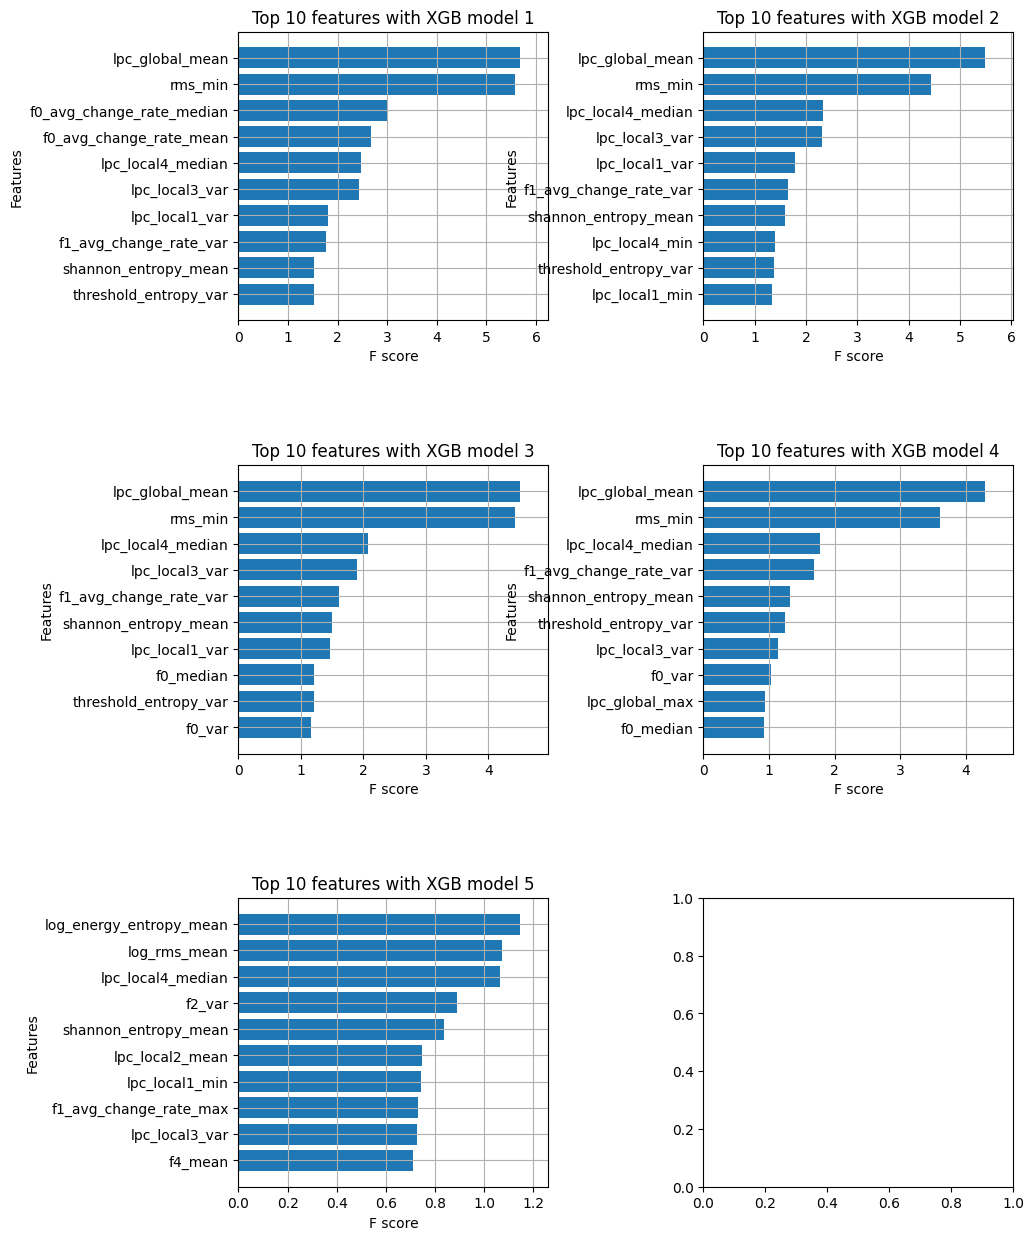

    Completed XGBoost feature selection in 2 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 16 important features:
['lpc_global_mean', 'rms_min', 'f0_avg_change_rate_median', 'f0_avg_change_rate_mean', 'lpc_local4_median', 'lpc_local3_var', 'lpc_local1_var', 'f1_avg_change_rate_var', 'shannon_entropy_mean', 'threshold_entropy_var', 'shannon_entropy_max', 'f0_var', 'lpc_local3_max', 'lpc_local4_min', 'log_energy_entropy_mean', 'log_rms_mean']
Total Time taken for featurewiz selection = 8 seconds
Output contains a list of 16 important features and a train dataframe


In [12]:
# automatic feature selection by using featurewiz package
target = 'label'
 
features_all, df_paper1_reduced = featurewiz(df_paper1, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [13]:
# load the train/test data with selected features only
X_train, X_test, y_train, y_test = load_train_test_data(df_paper1_reduced, test_size=0.15, verbose=False)
num_classes = y_train.nunique()
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)

In [14]:
# define train, test, and val loader
train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, 
                       worker_init_fn=seed_worker,generator=g)

### MLP

In [15]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [16]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device, patience=10)

Epoch 1/25, Train Loss: 1.9057, Val Loss: 1.8764, Val F1 Macro: 0.2008
Epoch 2/25, Train Loss: 1.7859, Val Loss: 1.7915, Val F1 Macro: 0.2630
Epoch 3/25, Train Loss: 1.6370, Val Loss: 1.6772, Val F1 Macro: 0.3821
Epoch 4/25, Train Loss: 1.4692, Val Loss: 1.4121, Val F1 Macro: 0.4085
Epoch 5/25, Train Loss: 1.3079, Val Loss: 1.3654, Val F1 Macro: 0.5004
Epoch 6/25, Train Loss: 1.1956, Val Loss: 1.1479, Val F1 Macro: 0.4972
Epoch 7/25, Train Loss: 1.0768, Val Loss: 1.1423, Val F1 Macro: 0.5291
Epoch 8/25, Train Loss: 0.9804, Val Loss: 1.1222, Val F1 Macro: 0.5250
Epoch 9/25, Train Loss: 0.9632, Val Loss: 1.0949, Val F1 Macro: 0.5458
Epoch 10/25, Train Loss: 0.9025, Val Loss: 0.9998, Val F1 Macro: 0.5747
Epoch 11/25, Train Loss: 0.8902, Val Loss: 1.0998, Val F1 Macro: 0.5747
Epoch 12/25, Train Loss: 0.8339, Val Loss: 1.1694, Val F1 Macro: 0.5527
Epoch 13/25, Train Loss: 0.8164, Val Loss: 1.0362, Val F1 Macro: 0.5495
Epoch 14/25, Train Loss: 0.7879, Val Loss: 1.0733, Val F1 Macro: 0.5243
E


Evaluation: f1_score
73.33% for the train data
60.44% for the test data

Evaluation: accuracy_score
75.99% for the train data
63.41% for the test data

Evaluation: precision_score
75.64% for the train data
62.10% for the test data

Evaluation: recall_score
73.69% for the train data
61.67% for the test data

Evaluation: confusion_matrix of test predictions


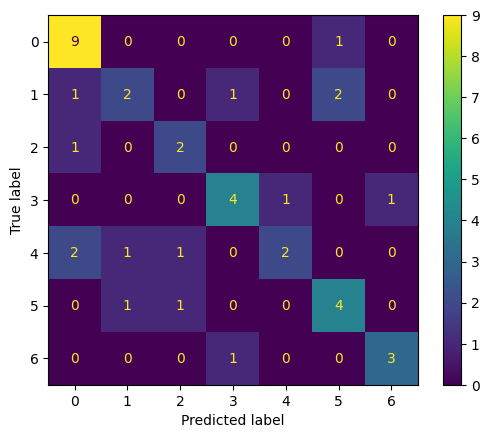


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['happiness(4)', 'neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['happiness(4)', 'neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['fear(3)']



In [17]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### GFFNN

In [18]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [19]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device, patience=10)

Epoch 1/25, Train Loss: 1.8018, Val Loss: 1.6653, Val F1 Macro: 0.4135
Epoch 2/25, Train Loss: 1.5412, Val Loss: 1.5382, Val F1 Macro: 0.5308
Epoch 3/25, Train Loss: 1.3457, Val Loss: 1.4575, Val F1 Macro: 0.5019
Epoch 4/25, Train Loss: 1.2220, Val Loss: 1.2271, Val F1 Macro: 0.5381
Epoch 5/25, Train Loss: 1.1164, Val Loss: 1.2334, Val F1 Macro: 0.5313
Epoch 6/25, Train Loss: 1.0617, Val Loss: 1.0570, Val F1 Macro: 0.5313
Epoch 7/25, Train Loss: 0.9920, Val Loss: 1.1060, Val F1 Macro: 0.4955
Epoch 8/25, Train Loss: 0.9201, Val Loss: 1.1067, Val F1 Macro: 0.5252
Epoch 9/25, Train Loss: 0.9229, Val Loss: 1.0858, Val F1 Macro: 0.4955
Epoch 10/25, Train Loss: 0.8761, Val Loss: 1.0365, Val F1 Macro: 0.5310
Epoch 11/25, Train Loss: 0.8724, Val Loss: 1.1166, Val F1 Macro: 0.5310
Epoch 12/25, Train Loss: 0.8234, Val Loss: 1.1022, Val F1 Macro: 0.5310
Epoch 13/25, Train Loss: 0.8046, Val Loss: 1.0812, Val F1 Macro: 0.5310
Epoch 14/25, Train Loss: 0.7897, Val Loss: 1.0140, Val F1 Macro: 0.5355
N


Evaluation: f1_score
70.61% for the train data
62.69% for the test data

Evaluation: accuracy_score
72.69% for the train data
63.41% for the test data

Evaluation: precision_score
71.86% for the train data
66.73% for the test data

Evaluation: recall_score
70.41% for the train data
61.43% for the test data

Evaluation: confusion_matrix of test predictions


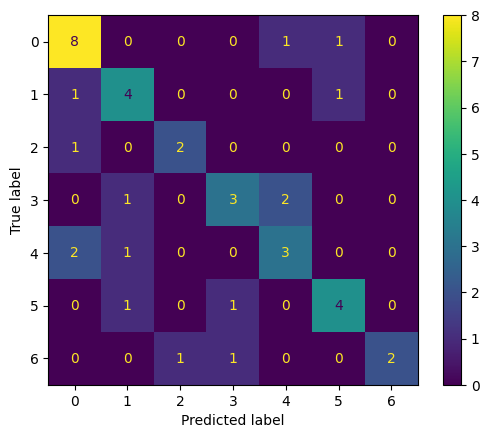


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['sadness(6)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: sadness(6)
Hard cases of false negatives: ['disgust(2)', 'fear(3)']



In [20]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

Feature selection in this small subset does not help at all.

### Repeat with 90-5-5 as they did in paper

In [21]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_paper1, test_size=0.1)
num_classes = y_train.nunique()
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)

A snippet of the data:


,median,min,var,f1_median,f1_max,f1_mean,f1_std,f1_var,f2_median,f2_max,...,f3_avg_change_rate_min,f3_avg_change_rate_mean,f3_avg_change_rate_median,f3_avg_change_rate_var,f4_min,f4_avg_change_rate_max,f4_avg_change_rate_min,f4_avg_change_rate_mean,f4_avg_change_rate_median,f4_avg_change_rate_var
237,0.179508,-0.652108,0.398483,-0.910195,0.867241,-0.836544,0.972100,0.818601,-0.675433,2.301220,...,0.281342,-0.571515,-2.421321,1.134351,2.532017,-1.128242,0.936666,-0.642279,-1.023195,-0.050438
459,0.228894,-0.652108,-0.451518,-0.594862,0.479114,-0.582301,0.051272,-0.082693,0.169959,-0.188910,...,-0.435149,1.212373,0.212935,-0.207111,0.108335,-1.018174,1.073194,0.839805,-0.068708,-1.061572
142,2.464448,-0.652108,3.804069,-1.235926,0.811069,-0.218788,1.109326,0.971293,0.258974,3.024731,...,-1.732089,-1.071855,0.958744,0.370705,-1.027376,-0.454119,0.359252,-0.102290,-0.291171,-0.342364
148,0.984505,-0.652108,0.124783,-0.377024,0.002248,-0.514863,-0.171951,-0.268858,1.033327,0.275566,...,-0.168794,-0.715513,0.004755,0.726086,-0.191502,0.458023,-1.160187,0.005342,0.679895,2.186467
124,-1.093013,1.606945,-1.157279,1.591598,-1.310297,1.488478,-0.280482,-0.354813,0.797993,-1.158205,...,-1.441704,0.283201,-0.938220,-0.189211,0.432228,-0.226709,0.064645,0.431431,0.364636,-0.685866


There are 481 entries with 108 columns in the training data.
There are 54 entries with 108 columns in the testing data.


In [22]:
# define train, test, and val loader
train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, 
                       worker_init_fn=seed_worker,generator=g)

### MLP

In [47]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [48]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device, patience=10)

Epoch 1/25, Train Loss: 1.8801, Val Loss: 1.7559, Val F1 Macro: 0.2667
Epoch 2/25, Train Loss: 1.6323, Val Loss: 1.5002, Val F1 Macro: 0.2279
Epoch 3/25, Train Loss: 1.3210, Val Loss: 1.3121, Val F1 Macro: 0.2279
Epoch 4/25, Train Loss: 1.1800, Val Loss: 1.1351, Val F1 Macro: 0.3519
Epoch 5/25, Train Loss: 1.0363, Val Loss: 1.0185, Val F1 Macro: 0.3951
Epoch 6/25, Train Loss: 0.8880, Val Loss: 0.9234, Val F1 Macro: 0.3905
Epoch 7/25, Train Loss: 0.7936, Val Loss: 0.8469, Val F1 Macro: 0.5446
Epoch 8/25, Train Loss: 0.8036, Val Loss: 0.7964, Val F1 Macro: 0.5818
Epoch 9/25, Train Loss: 0.6162, Val Loss: 0.7384, Val F1 Macro: 0.7102
Epoch 10/25, Train Loss: 0.5675, Val Loss: 0.6675, Val F1 Macro: 0.7483
Epoch 11/25, Train Loss: 0.5338, Val Loss: 0.6722, Val F1 Macro: 0.7020
Epoch 12/25, Train Loss: 0.4920, Val Loss: 0.6074, Val F1 Macro: 0.7107
Epoch 13/25, Train Loss: 0.4296, Val Loss: 0.5965, Val F1 Macro: 0.7153
Epoch 14/25, Train Loss: 0.3889, Val Loss: 0.5305, Val F1 Macro: 0.7616
E


Evaluation: f1_score
98.24% for the train data
63.30% for the test data

Evaluation: accuracy_score
98.13% for the train data
66.67% for the test data

Evaluation: precision_score
98.32% for the train data
71.05% for the test data

Evaluation: recall_score
98.21% for the train data
63.44% for the test data

Evaluation: confusion_matrix of test predictions


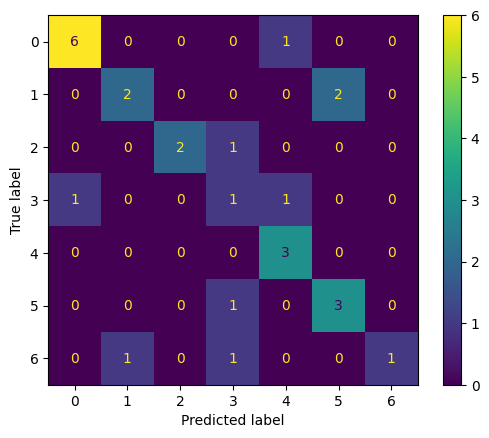


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['sadness(6)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)', 'happiness(4)']
Hard cases of false positives: ['disgust(2)', 'neutral(5)', 'sadness(6)']

Label: neutral(5)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)', 'fear(3)']



In [49]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### GFFNN

In [50]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [51]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device, patience=10)

Epoch 1/25, Train Loss: 1.6590, Val Loss: 1.3055, Val F1 Macro: 0.4626
Epoch 2/25, Train Loss: 1.2208, Val Loss: 1.1203, Val F1 Macro: 0.4437
Epoch 3/25, Train Loss: 1.0087, Val Loss: 0.9750, Val F1 Macro: 0.5769
Epoch 4/25, Train Loss: 0.9181, Val Loss: 0.8882, Val F1 Macro: 0.4959
Epoch 5/25, Train Loss: 0.7930, Val Loss: 0.8222, Val F1 Macro: 0.5272
Epoch 6/25, Train Loss: 0.7007, Val Loss: 0.7474, Val F1 Macro: 0.6340
Epoch 7/25, Train Loss: 0.6286, Val Loss: 0.7097, Val F1 Macro: 0.6340
Epoch 8/25, Train Loss: 0.6556, Val Loss: 0.6875, Val F1 Macro: 0.6707
Epoch 9/25, Train Loss: 0.5166, Val Loss: 0.6610, Val F1 Macro: 0.6740
Epoch 10/25, Train Loss: 0.4723, Val Loss: 0.6192, Val F1 Macro: 0.6707
Epoch 11/25, Train Loss: 0.4611, Val Loss: 0.5842, Val F1 Macro: 0.6707
Epoch 12/25, Train Loss: 0.4421, Val Loss: 0.5699, Val F1 Macro: 0.6835
Epoch 13/25, Train Loss: 0.3712, Val Loss: 0.5690, Val F1 Macro: 0.7787
Epoch 14/25, Train Loss: 0.3385, Val Loss: 0.5219, Val F1 Macro: 0.7673
E


Evaluation: f1_score
98.28% for the train data
63.67% for the test data

Evaluation: accuracy_score
98.34% for the train data
66.67% for the test data

Evaluation: precision_score
98.37% for the train data
70.48% for the test data

Evaluation: recall_score
98.20% for the train data
63.44% for the test data

Evaluation: confusion_matrix of test predictions


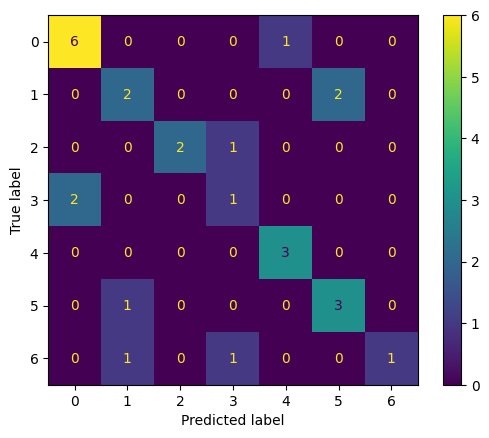


Hard cases for the model:

Label: anger(0)
Hard cases of false positives: ['fear(3)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)', 'sadness(6)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['disgust(2)', 'sadness(6)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)', 'fear(3)']



In [52]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

## Best Model GFFNN with PCA

In [64]:
pca = PCA(0.9)
principalComponents = pca.fit_transform(df_all_stats.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df[['label']]], axis = 1)

print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

103
[0.1371097  0.1225378  0.04878109 0.04306813 0.03503977 0.03143388
 0.02841167 0.02122009 0.01921022 0.01644826 0.01569456 0.01476704
 0.01442153 0.01311755 0.01305086 0.01188505 0.01135937 0.01061576
 0.01011364 0.00922488 0.00884234 0.00823372 0.00770304 0.00751619
 0.0071806  0.00701369 0.00693512 0.00659679 0.00637725 0.00610694
 0.00588616 0.00584404 0.00550799 0.00536687 0.00504853 0.00482218
 0.00472164 0.00452798 0.00438488 0.00430476 0.00414801 0.00408645
 0.0040593  0.00381127 0.00378764 0.00361238 0.00355297 0.00350895
 0.00345933 0.00336829 0.00329617 0.00314747 0.00311828 0.00304889
 0.0029914  0.00296533 0.00284535 0.0028187  0.00276443 0.0027123
 0.00267024 0.00261958 0.00260387 0.00251982 0.00244606 0.00243382
 0.0023608  0.00232406 0.00227299 0.00225475 0.00222684 0.00218453
 0.0021589  0.00212355 0.00208363 0.00205167 0.00204371 0.00196448
 0.00195309 0.00193649 0.00193473 0.00188694 0.00186865 0.00183865
 0.00183572 0.00179142 0.00176027 0.00173093 0.00172303 0.0

In [65]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_paper1, test_size=0.3, verbose=False)
num_classes = y_train.nunique()
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)

In [66]:
# define train, test, and val loader
train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, 
                          worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True, 
                        worker_init_fn=seed_worker,generator=g)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, 
                       worker_init_fn=seed_worker,generator=g)

In [67]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [68]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device, patience=10)

Epoch 1/25, Train Loss: 1.6963, Val Loss: 1.3949, Val F1 Macro: 0.3996
Epoch 2/25, Train Loss: 1.2647, Val Loss: 1.1410, Val F1 Macro: 0.5556
Epoch 3/25, Train Loss: 1.0490, Val Loss: 1.0539, Val F1 Macro: 0.5690
Epoch 4/25, Train Loss: 0.8977, Val Loss: 0.9246, Val F1 Macro: 0.6589
Epoch 5/25, Train Loss: 0.7814, Val Loss: 0.8069, Val F1 Macro: 0.7150
Epoch 6/25, Train Loss: 0.6835, Val Loss: 0.8095, Val F1 Macro: 0.7396
Epoch 7/25, Train Loss: 0.6090, Val Loss: 0.7310, Val F1 Macro: 0.7569
Epoch 8/25, Train Loss: 0.5414, Val Loss: 0.6616, Val F1 Macro: 0.7581
Epoch 9/25, Train Loss: 0.4811, Val Loss: 0.6526, Val F1 Macro: 0.7537
Epoch 10/25, Train Loss: 0.4264, Val Loss: 0.6090, Val F1 Macro: 0.7914
Epoch 11/25, Train Loss: 0.3678, Val Loss: 0.6088, Val F1 Macro: 0.7901
Epoch 12/25, Train Loss: 0.3257, Val Loss: 0.5562, Val F1 Macro: 0.7938
Epoch 13/25, Train Loss: 0.2918, Val Loss: 0.6236, Val F1 Macro: 0.8054
Epoch 14/25, Train Loss: 0.2502, Val Loss: 0.5800, Val F1 Macro: 0.7714
E


Evaluation: f1_score
99.78% for the train data
68.64% for the test data

Evaluation: accuracy_score
99.73% for the train data
74.07% for the test data

Evaluation: precision_score
99.84% for the train data
72.08% for the test data

Evaluation: recall_score
99.71% for the train data
70.13% for the test data

Evaluation: confusion_matrix of test predictions


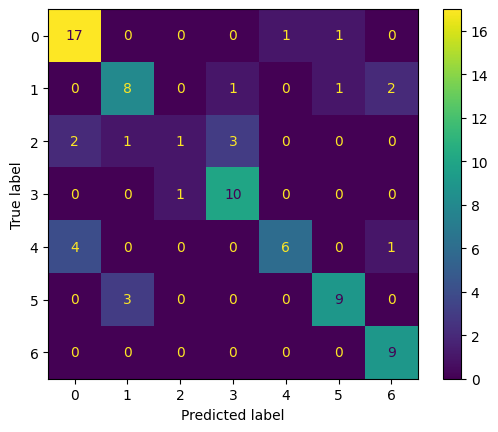


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'fear(3)']
Hard cases of false positives: ['fear(3)']

Label: fear(3)
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [69]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)